Import Libraries

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR
# from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score

from xgboost import XGBRegressor


In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the dataset

In [51]:
train_path = "./Datasets/train.csv"
test_path = "./Datasets/test.csv"
output_path = "./Datasets/output.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

X_train = train_data.drop(columns='monthly_rent')
y_train = train_data['monthly_rent']

See X_train distribution

In [52]:
X_train.shape

(60000, 15)

In [53]:
X_train.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region


In [54]:
X_train.nunique()

rent_approval_date       31
town                     26
block                  2553
street_name            1083
flat_type                 9
flat_model               19
floor_area_sqm          146
furnished                 1
lease_commence_date      54
latitude               8612
longitude              8612
elevation                 1
subzone                 152
planning_area            29
region                    5
dtype: int64

In [55]:
X_train.isna().sum()

rent_approval_date     0
town                   0
block                  0
street_name            0
flat_type              0
flat_model             0
floor_area_sqm         0
furnished              0
lease_commence_date    0
latitude               0
longitude              0
elevation              0
subzone                0
planning_area          0
region                 0
dtype: int64

Data preprocessing of X_train

In [56]:
def data_preprocessing(data):
    data.replace("-", " ", regex=True, inplace=True)

    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = data[col].str.lower()
    
    data['lease_commence_date'] = 2021 - data['lease_commence_date']

    def convert_to_numeric(date_str):
        year, month = date_str.split(" ")
        return float(year) + float(month)/12.0
    data['rent_approval_date'] = [convert_to_numeric(date) for date in data['rent_approval_date']]

    return data

X_train = data_preprocessing(X_train)


Feature Engineering of X_train

In [57]:
X_train_num = X_train.select_dtypes(include = ['float64', 'int64'])
print(X_train_num.shape)
X_train_num.head()

(60000, 6)


,rent_approval_date,floor_area_sqm,lease_commence_date,latitude,longitude,elevation
0,2021.750000,67.0,38,1.344518,103.738630,0.0
1,2022.416667,92.0,43,1.330186,103.938717,0.0
2,2022.833333,67.0,50,1.332242,103.845643,0.0
3,2021.666667,149.0,28,1.370239,103.962894,0.0
4,2022.916667,68.0,49,1.320502,103.863341,0.0


In [58]:
X_train_cat = X_train.select_dtypes(include = ['object'])
print(X_train_cat.shape)
X_train_cat.head()

(60000, 9)


,town,block,street_name,flat_type,flat_model,furnished,subzone,planning_area,region
0,jurong east,257,jurong east street 24,3 room,new generation,yes,yuhua east,jurong east,west region
1,bedok,119,bedok north road,4 room,new generation,yes,bedok north,bedok,east region
2,toa payoh,157,lorong 1 toa payoh,3 room,improved,yes,toa payoh central,toa payoh,central region
3,pasir ris,250,pasir ris street 21,executive,apartment,yes,pasir ris drive,pasir ris,east region
4,kallang/whampoa,34,whampoa west,3 room,improved,yes,bendemeer,kallang,central region


array([[<AxesSubplot:title={'center':'rent_approval_date'}>,
        <AxesSubplot:title={'center':'floor_area_sqm'}>],
       [<AxesSubplot:title={'center':'lease_commence_date'}>,
        <AxesSubplot:title={'center':'latitude'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'elevation'}>]], dtype=object)

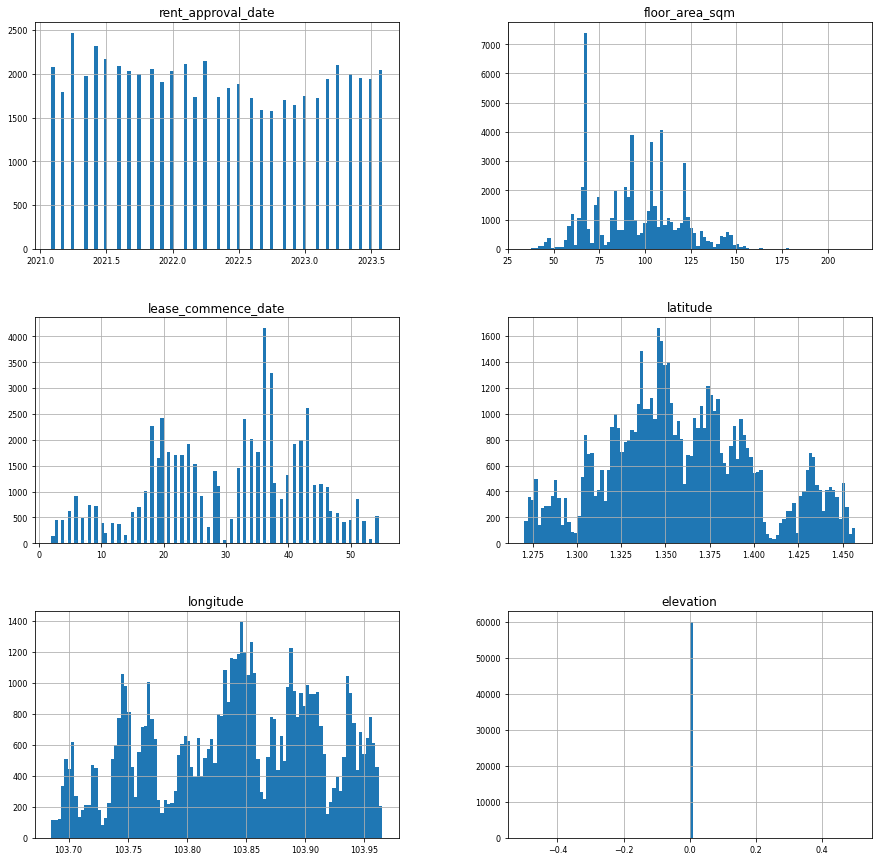

In [59]:
X_train_num.hist(figsize=(15, 15), bins=100, xlabelsize=8, ylabelsize=8)

<AxesSubplot:>

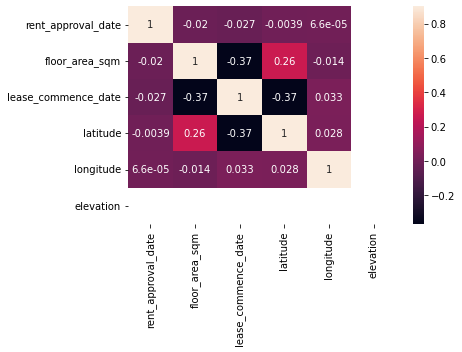

In [60]:
corrmat = X_train_num.corr()
sns.heatmap(corrmat, vmax=.9, annot=True)

In [61]:
def feature_engineering(data):
    # numerical feature
    data_num = data.select_dtypes(include = ['float64', 'int64'])
    data_num = data_num[['rent_approval_date', 'floor_area_sqm', 'lease_commence_date']]

    # categorical feature
    data_cat = data.select_dtypes(include = ['object'])
    data_cat_one_hot = pd.get_dummies(data[['flat_type', 'flat_model', 'region', 'town', 'planning_area']]) #

    # Concate all the choosed features
    data_filter = pd.concat([data_num, data_cat_one_hot], axis=1)

    return data_filter

X_train = feature_engineering(X_train)
X_train.head()
    

,rent_approval_date,floor_area_sqm,lease_commence_date,flat_type_2 room,flat_type_3 room,flat_type_4 room,flat_type_5 room,flat_type_executive,flat_model_2 room,flat_model_3gen,...,planning_area_punggol,planning_area_queenstown,planning_area_rochor,planning_area_sembawang,planning_area_sengkang,planning_area_serangoon,planning_area_tampines,planning_area_toa payoh,planning_area_woodlands,planning_area_yishun
0,2021.750000,67.0,38,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2022.416667,92.0,43,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2022.833333,67.0,50,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,2021.666667,149.0,28,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2022.916667,68.0,49,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Visualize y_train distribution

count    60000.000000
mean      2590.328333
std        714.910468
min        300.000000
25%       2100.000000
50%       2400.000000
75%       3000.000000
max       6950.000000
Name: monthly_rent, dtype: float64


<Figure size 432x288 with 0 Axes>

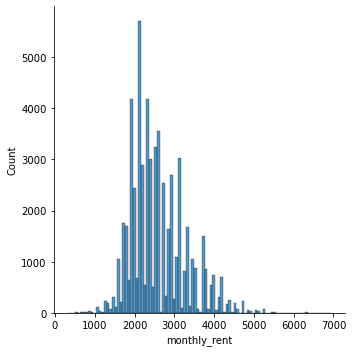

In [62]:
print(y_train.describe())
plt.figure()
sns.displot(y_train, bins=100)

In [63]:
# y_train = np.log1p(y_train)

# print(y_train.describe())
# plt.figure()
# sns.displot(y_train, bins=100)

Train-Test Split

In [64]:
X, y = X_train, y_train
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Define evaluation metrics

In [65]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
    return rmse

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r_squared = r2_score(y, predictions)
    return mae, mse, rmse, r_squared

linear Regression

In [66]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions = lin_reg.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(lin_reg)
print("RMSE Cross-Validation:", rmse_cross_val)

MAE: 389.58780847631425
MSE: 255430.08667359236
RMSE: 505.4009167716184
R2 Score: 0.49367243638565983
------------------------------
RMSE Cross-Validation: 505.76495181978873


Ridge Regression

In [ ]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(ridge)
print("RMSE Cross-Validation:", rmse_cross_val)

MAE: 389.54380306003753
MSE: 255382.445376885
RMSE: 505.35378239099487
R2 Score: 0.49376687358373395
------------------------------
RMSE Cross-Validation: 505.7212749846958


Random Forest Regressor

In [ ]:
# random_forest = RandomForestRegressor(n_estimators=100)
# random_forest.fit(X_train, y_train)
# predictions = random_forest.predict(X_test)

# mae, mse, rmse, r_squared = evaluation(y_test, predictions)
# print("MAE:", mae)
# print("MSE:", mse)
# print("RMSE:", rmse)
# print("R2 Score:", r_squared)
# print("-"*30)
# rmse_cross_val = rmse_cv(random_forest)
# print("RMSE Cross-Validation:", rmse_cross_val)

XGBoost Regressor

In [24]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(xgb)
print("RMSE Cross-Validation:", rmse_cross_val)

MAE: 367.80087479654946
MSE: 236404.20813469353
RMSE: 486.2141587147515
R2 Score: 0.5313865790368864
------------------------------
RMSE Cross-Validation: 488.50003602993047


Predicet test dataset

In [67]:
test_data = data_preprocessing(test_data)
test_data = feature_engineering(test_data)

test_data.head()

,rent_approval_date,floor_area_sqm,lease_commence_date,flat_type_2 room,flat_type_3 room,flat_type_4 room,flat_type_5 room,flat_type_executive,flat_model_2 room,flat_model_adjoined flat,...,planning_area_punggol,planning_area_queenstown,planning_area_rochor,planning_area_sembawang,planning_area_sengkang,planning_area_serangoon,planning_area_tampines,planning_area_toa payoh,planning_area_woodlands,planning_area_yishun
0,2023.083333,121.0,37,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2022.750000,100.0,22,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,2023.583333,91.0,41,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2021.666667,74.0,35,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2022.250000,121.0,38,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [68]:
test_data = test_data.reindex(columns=X_train.columns, fill_value=False)

test_data.head()

,rent_approval_date,floor_area_sqm,lease_commence_date,flat_type_2 room,flat_type_3 room,flat_type_4 room,flat_type_5 room,flat_type_executive,flat_model_2 room,flat_model_3gen,...,planning_area_punggol,planning_area_queenstown,planning_area_rochor,planning_area_sembawang,planning_area_sengkang,planning_area_serangoon,planning_area_tampines,planning_area_toa payoh,planning_area_woodlands,planning_area_yishun
0,2023.083333,121.0,37,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2022.750000,100.0,22,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,2023.583333,91.0,41,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2021.666667,74.0,35,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2022.250000,121.0,38,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [69]:
test_pred = lin_reg.predict(test_data)
test_pred

array([3023.33963153, 2686.88058052, 3462.21110126, ..., 2801.36433664,
       3252.69229202, 3496.440933  ])

In [70]:
sample_submission_path = './Datasets/example-submission.csv'
sample_submission_df = pd.read_csv(sample_submission_path)
sample_submission_df['Predicted'] = test_pred
sample_submission_df.to_csv('./Datasets/submission.csv', index=False)
sample_submission_df.head()

,Id,Predicted
0,0,3023.339632
1,1,2686.880581
2,2,3462.211101
3,3,1928.391350
4,4,2766.717751
